# Exploratory Data Analysis and Feature Engineering

Goal of this notebook is to analyze the delta between creation of shipment and first hub scan (FHS) which happens when the parcel arrives at the last mile carrier. this time includes the time of transport which is our target.

In [1]:
%load_ext autoreload
%autoreload 2

Installing packages from requirements.txt (Output hidden)

In [2]:
%%capture
!pip install -e ../.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from dispatcher.data.data import RawData
from dispatcher.data.data import save_clean_shipment_data
from dispatcher.data.ticket import Ticket
from dispatcher.data.shipment import Shipment

## Loading

Let's load the `shipment` table using the `get_table_data` method from the `RawData` class. Param `clean` set to False, as we want to look at the raw data.

The data schema with all the tables:
![Data Schema](data_schema.png "Data Schema")


We want to use features from the tables `shipment`, `ticket`, and `ticket_type` to construct our target. The index of the final table should be the `SHIPMENT_ID`, as we want to analyze on shipment-level.

In [4]:
shipment = RawData.get_table_data('shipment', clean=False)
shipment.head(3)

/var/folders/_7/bhnzdc191yv6brswc0vzw5sr0000gn/T/ipykernel_23018/2084993844.py:1: DtypeWarning: Columns (4,12,22,24,26) have mixed types.Specify dtype option on import or set low_memory=False.
  shipment = RawData.get_table_data('shipment', clean=False)


,ID,CARRIER_ID,SHOP_ID,CUSTOMER_ADDRESS_COUNTRY_ID,CUSTOMER_ADDRESS_ZIP_CODE,CARRIER_SERVICE,RETURN_PARCEL,PICKUP_POINT_SELECTED,WEIGHT,PLANNED_PICKUP_TIMESTAMP,...,RELATION_ID,RELATION_DISTANCE,RELATION_FREQUENCY,LOGISTICAL_DETAILS,RELATION_SEVEN_SENDERS_TRANSPORT_MODE,TMS_RELATION_TYPE,ORIGIN_ZIP_CODE,ORIGIN_COUNTRY,DESTINATION_ZIP_CODE,DESTINATION_COUNTRY
0,169412848,2,405,216,8400,standard,0,0,6.2,2022-03-04 17:26:56.000,...,323,284.537697,5.0,"Handover of parcels on one-way pallets: (1,20m...",NaN,outbound,96138,DE,9000,CH
1,169265841,2,405,216,1015,standard,0,0,26.3,2022-03-03 19:23:57.000,...,323,284.537697,5.0,"Handover of parcels on one-way pallets: (1,20m...",NaN,outbound,96138,DE,9000,CH
2,170520112,2,405,216,6153,standard,0,0,8.4,2022-03-11 15:43:42.000,...,323,284.537697,5.0,"Handover of parcels on one-way pallets: (1,20m...",NaN,outbound,96138,DE,9000,CH


In [5]:
shipment.keys()

Index(['ID', 'CARRIER_ID', 'SHOP_ID', 'CUSTOMER_ADDRESS_COUNTRY_ID',
       'CUSTOMER_ADDRESS_ZIP_CODE', 'CARRIER_SERVICE', 'RETURN_PARCEL',
       'PICKUP_POINT_SELECTED', 'WEIGHT', 'PLANNED_PICKUP_TIMESTAMP',
       'CREATED_AT', 'SHIPMENT_STATUS_ID', 'WAREHOUSE_ADDRESS', 'WAREHOUSE_ID',
       'ORDER_ID', 'SLA_DAYS', 'TRACKABLE', 'SEVEN_SENDERS_TAG', 'RELATION_ID',
       'RELATION_DISTANCE', 'RELATION_FREQUENCY', 'LOGISTICAL_DETAILS',
       'RELATION_SEVEN_SENDERS_TRANSPORT_MODE', 'TMS_RELATION_TYPE',
       'ORIGIN_ZIP_CODE', 'ORIGIN_COUNTRY', 'DESTINATION_ZIP_CODE',
       'DESTINATION_COUNTRY'],
      dtype='object')

Let's throw out columns which are not potentially useful for predicting the time of transport.

In [6]:
shipment = shipment[['ID', 'CARRIER_ID', 'SHOP_ID', 'CUSTOMER_ADDRESS_COUNTRY_ID',
       'CUSTOMER_ADDRESS_ZIP_CODE', 'RETURN_PARCEL', 'PLANNED_PICKUP_TIMESTAMP',
       'CREATED_AT', 'WAREHOUSE_ID',
       'ORDER_ID', 'SLA_DAYS', 'RELATION_ID', 'RELATION_DISTANCE',
       'ORIGIN_ZIP_CODE', 'ORIGIN_COUNTRY', 'DESTINATION_ZIP_CODE',
       'DESTINATION_COUNTRY']]

Most important feature here is the `CREATED_AT` timestamp which we will use with features from other tables to calculate the target.

Same procedure goes for the `ticket` table:

In [7]:
ticket = RawData.get_table_data('ticket', clean=False)
ticket.head(3)

,ID,SHIPMENT_ID,STATUS_ID,NOTES,TYPE_ID,CREATEDAT,SHIPMENT_TIMELINE_ID,STATUS,RECORD_UPDATED_AT,ORDER_ID,SHOP_ID,TIME
0,1991335581,170551890.0,NaN,NaN,38,2022-05-13 05:31:35.000,994191806.0,new,2022-05-13 05:31:35.000,NaN,196,2022-03-15 10:45:00.000
1,1991335583,170551890.0,NaN,NaN,33,2022-05-13 05:31:35.000,994191806.0,new,2022-05-13 05:31:35.000,NaN,196,2022-03-15 10:45:00.000
2,1991335585,171118033.0,NaN,NaN,38,2022-05-13 05:31:36.000,994191808.0,new,2022-05-13 05:31:36.000,NaN,196,2022-03-18 10:32:00.000


In [8]:
ticket = ticket[['ID', 'SHIPMENT_ID', 'TYPE_ID',
       'ORDER_ID',
       'TIME']]

Now we'll do the loading and selecting for the `ticket_type` table, from which we are only going to use the `NAME` column, which describes the type of the ticket in one or two words.

In [9]:
ticket_type = RawData.get_table_data('ticket_type', clean=False)
ticket_type.head(3)

,ID,NAME,DESCRIPTION,CREATEDAT,EVENT_NAME,LEVEL,MEANING,LIMIT_OCCURRENCES,PARENT_ID,SEQUENCE_NUMBER,IS_CUSTOM,RECORD_UPDATED_AT,TRACKABLE,ACTIVE
0,1,Carded,Customer received a notification card inside h...,NaN,NaN,shipment,good,1,NaN,NaN,0,2018-07-31 09:08:05.000,1,1
1,2,Wrong address,Consignee address not correct. Please contact ...,NaN,NaN,shipment,really_bad,-1,NaN,NaN,0,2018-07-31 09:08:05.000,1,1
2,3,Light damage,Shipment was damaged but is still on the way t...,NaN,NaN,shipment,bad,-1,NaN,NaN,0,2018-07-31 09:08:05.000,1,1


In [10]:
ticket_type = ticket_type[['ID', 'NAME']]

## Merging and Feature Creation

Let's first merge the tables `ticket` and `ticket_type`:

In [11]:
ticket = ticket.merge(ticket_type, how='left', left_on='TYPE_ID', right_on='ID')

Next we'll have a look at the rows with `TICKET_ID` = 17, which is first hub scan (FHS). We want to create a new feature with the timestamp of the FHS. 

To achieve this, we'll have to do a little workaround, because we want to have the timestamp for every `SHIPMENT_ID` (row) of the final DataFrame. If we would directly write it in the `ticket` table und directly merge with the `shipment` table, all the rows with different `TYPE_ID` would stay empty. That's why we'll use two temporary DataFrames.

 We'll create a new feature out of the timestamp of the FHS and save it into the temporary DataFrame `tmp`.

In [12]:
ticket['FHS'] = ticket.loc[ticket["TYPE_ID"] == 17]['TIME']

In [13]:
tmp = ticket[['SHIPMENT_ID', 'FHS']]

In [14]:
ticket = ticket.drop(columns="FHS")

We'll drop NAs for this temporary DataFrame. This way we can make sure to have only one row per ticket in the DataFrame, which includes the timestamp FHS.

*Note: A prerequisite for this to work is the fact, that every shipment has an FHS.*

In [15]:
tmp = tmp.dropna(subset=['FHS'])

This DataFrame only contains the ticket rows where the FHS was happening.

Now we will also create a new feature with the timestamp of `SHIPMENT_CREATED`, save it into `tmp2` and drop NAs. Just like above for the FHS.

In [16]:
ticket['SHIPMENT_CREATED'] = ticket.loc[ticket["NAME"] == 'Shipment created']['TIME']

In [17]:
tmp2 = ticket[['SHIPMENT_ID', 'SHIPMENT_CREATED']]

In [18]:
ticket = ticket.drop(columns="SHIPMENT_CREATED")

In [19]:
tmp2 = tmp2.dropna(subset=['SHIPMENT_CREATED'])

This DataFrame only contains the ticket rows where the shipment was created.

Now let's merge the `shipment` and `ticket` tables:

In [20]:
shipment_ticket = shipment.merge(ticket, how='left', left_on='ID', right_on='SHIPMENT_ID')

In [21]:
shipment_ticket.isnull().sum() * 100 / len(shipment_ticket)

ID                               0.000000
CARRIER_ID                       0.000000
SHOP_ID                          0.000000
CUSTOMER_ADDRESS_COUNTRY_ID      0.000000
CUSTOMER_ADDRESS_ZIP_CODE        0.000407
RETURN_PARCEL                    0.000000
PLANNED_PICKUP_TIMESTAMP         0.000000
CREATED_AT                       0.000000
WAREHOUSE_ID                     0.000000
ORDER_ID_x                       0.000000
SLA_DAYS                        63.034354
RELATION_ID                      0.000000
RELATION_DISTANCE                7.059264
ORIGIN_ZIP_CODE                  6.131718
ORIGIN_COUNTRY                   6.131718
DESTINATION_ZIP_CODE             7.059264
DESTINATION_COUNTRY              7.059264
ID_x                             0.010056
SHIPMENT_ID                      0.010056
TYPE_ID                          0.010056
ORDER_ID_y                     100.000000
TIME                             0.010056
ID_y                             0.010056
NAME                             0

Let's drop the columns with a lot of missing values and the columns with `_y` and `_x`, which are fragments from the merge:

In [22]:
shipment_ticket = shipment_ticket.drop(columns=['SLA_DAYS', 'ORDER_ID_y', 'ID_y', 'ID_x', 'ORDER_ID_x'])

Now we want to merge with the two temporary DataFrames, to get the two new features `FHS` and `SHIPMENT_CREATED` into our main DataFrame.

In [23]:
shipment_ticket = shipment_ticket.merge(tmp, how='left', left_on='ID', right_on='SHIPMENT_ID')

In [24]:
shipment_ticket = shipment_ticket.merge(tmp2, how='left', left_on='ID', right_on='SHIPMENT_ID')

Again let's drop the columns with `_y` and `_x`, which are fragments from the merge:

In [25]:
shipment_ticket = shipment_ticket.drop(columns=['SHIPMENT_ID', 'SHIPMENT_ID_x', 'SHIPMENT_ID_y'])

In [26]:
shipment_ticket.head(3)

,ID,CARRIER_ID,SHOP_ID,CUSTOMER_ADDRESS_COUNTRY_ID,CUSTOMER_ADDRESS_ZIP_CODE,RETURN_PARCEL,PLANNED_PICKUP_TIMESTAMP,CREATED_AT,WAREHOUSE_ID,RELATION_ID,RELATION_DISTANCE,ORIGIN_ZIP_CODE,ORIGIN_COUNTRY,DESTINATION_ZIP_CODE,DESTINATION_COUNTRY,TYPE_ID,TIME,NAME,FHS,SHIPMENT_CREATED
0,169412848,2,405,216,8400,0,2022-03-04 17:26:56.000,2022-03-04 16:26:58.000,604,323,284.537697,96138,DE,9000,CH,17.0,2022-03-10 16:25:01.000,First hub scan,2022-03-10 16:25:01.000,2022-03-04 16:26:58.000
1,169412848,2,405,216,8400,0,2022-03-04 17:26:56.000,2022-03-04 16:26:58.000,604,323,284.537697,96138,DE,9000,CH,40.0,2022-03-11 07:42:31.000,Out for delivery,2022-03-10 16:25:01.000,2022-03-04 16:26:58.000
2,169412848,2,405,216,8400,0,2022-03-04 17:26:56.000,2022-03-04 16:26:58.000,604,323,284.537697,96138,DE,9000,CH,55.0,2022-03-07 08:01:05.000,Delivery requested at the carrier's,2022-03-10 16:25:01.000,2022-03-04 16:26:58.000


Conversion of timestamps to datetime format:

In [27]:
shipment_ticket['FHS'] = pd.to_datetime(shipment_ticket['FHS'])

In [28]:
shipment_ticket['SHIPMENT_CREATED'] = pd.to_datetime(shipment_ticket['SHIPMENT_CREATED'])

In [29]:
shipment['CREATED_AT'] = pd.to_datetime(shipment['CREATED_AT'])

In [30]:
shipment_ticket['PLANNED_PICKUP_TIMESTAMP'] = pd.to_datetime(shipment_ticket['PLANNED_PICKUP_TIMESTAMP'])

## Target Creation
Now let's create our target:

In [31]:
shipment_ticket['FHS_MINUS_SHIPMENT_CREATED'] = shipment_ticket['FHS'] - shipment_ticket['SHIPMENT_CREATED']

Let's check if there are duplicates at the `SHIPMENT_ID`:

In [32]:
shipment_ticket.ID.value_counts(dropna=False, sort=False).reset_index(name='count')

,index,count
0,169412848,8
1,169265841,8
2,170520112,8
3,169681312,8
4,169641352,8
...,...,...
1693772,170415809,12
1693773,171551372,10
1693774,169788705,13
1693775,171768164,10


There are multiple rows per `SHIPMENT_ID`, as there are multiple tickets per shipment. We should drop these, as we are only interested in one row per shipment. 

In [33]:
shipment_times = shipment_ticket.drop_duplicates(subset=['ID'])[['ID','FHS', 'SHIPMENT_CREATED', 'FHS_MINUS_SHIPMENT_CREATED']]

Let's filter the target, as we are not interested in outliers. So we will use a maximum number of days (let's start with 3 days) and a minimum of 0 days.

In [34]:
#play with time horizon: change days parameter
shipment_times_filtered = shipment_times[shipment_times['FHS_MINUS_SHIPMENT_CREATED'] <= datetime.timedelta(days=7)]

In [35]:
shipment_times_filtered = shipment_times_filtered[shipment_times['FHS_MINUS_SHIPMENT_CREATED'] >= datetime.timedelta(days=0)]

/var/folders/_7/bhnzdc191yv6brswc0vzw5sr0000gn/T/ipykernel_23018/1584034457.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shipment_times_filtered = shipment_times_filtered[shipment_times['FHS_MINUS_SHIPMENT_CREATED'] >= datetime.timedelta(days=0)]


In [36]:
shipment_times_filtered.head(3)

,ID,FHS,SHIPMENT_CREATED,FHS_MINUS_SHIPMENT_CREATED
0,169412848,2022-03-10 16:25:01,2022-03-04 16:26:58,5 days 23:58:03
8,169265841,2022-03-09 15:32:34,2022-03-03 18:23:58,5 days 21:08:36
16,170520112,2022-03-15 22:19:45,2022-03-11 14:43:43,4 days 07:36:02


## Visualizations

Let's have a look at the distribution of the target. Remember that this is the time between creation of shipment at the  shipper warehouse and first hub scan at the last mile carrier hub.  
![Tracking Gap](tracking_gap.png "Tracking Gap")

<AxesSubplot:xlabel='FHS_MINUS_SHIPMENT_CREATED', ylabel='Percent'>

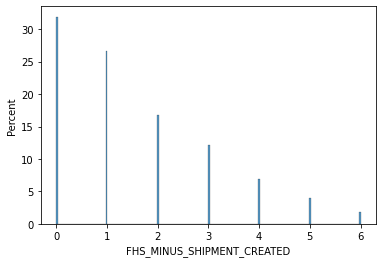

In [37]:
sns.histplot(shipment_times_filtered['FHS_MINUS_SHIPMENT_CREATED'].astype('timedelta64[D]'), stat='percent', kde=False)

We see that the vast majority arrives at the last mile carrier hub within 1, 2 or 3 days (Note that the bin at 0 corresponds to timeframes until 23:59 hrs). 

So let's have a closer look at the first 2 days on hour-level.

In [38]:
#play with time horizon: change days parameter
shipment_times_filtered = shipment_times[shipment_times['FHS_MINUS_SHIPMENT_CREATED'] <= datetime.timedelta(days=2)]

In [39]:
shipment_times_filtered = shipment_times_filtered[shipment_times['FHS_MINUS_SHIPMENT_CREATED'] >= datetime.timedelta(days=0)]

/var/folders/_7/bhnzdc191yv6brswc0vzw5sr0000gn/T/ipykernel_23018/1584034457.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shipment_times_filtered = shipment_times_filtered[shipment_times['FHS_MINUS_SHIPMENT_CREATED'] >= datetime.timedelta(days=0)]


<AxesSubplot:xlabel='FHS_MINUS_SHIPMENT_CREATED', ylabel='Percent'>

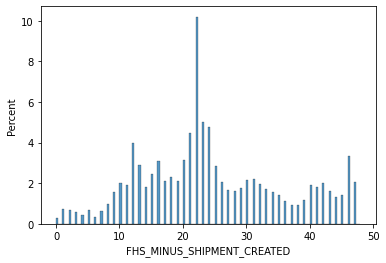

In [40]:
sns.histplot(shipment_times_filtered['FHS_MINUS_SHIPMENT_CREATED'].astype('timedelta64[h]'), stat='percent', kde=False)

There is a great peak at about 24 hours.

## Data Analysis

In [41]:
corr = shipment_ticket.corr(method ='pearson')

<AxesSubplot:>

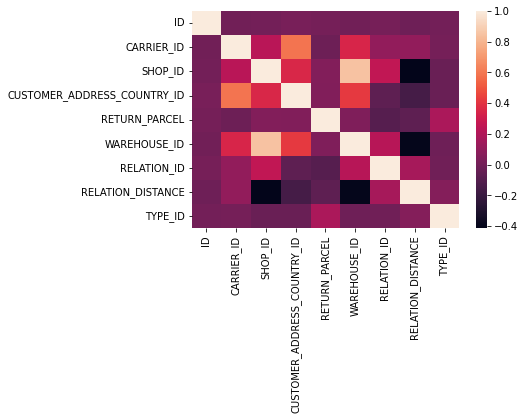

In [42]:
sns.heatmap(corr)

There are strong correlations between:
- `CARRIER_ID` and `CUSTOMER_ADDRESS_COUNTRY_ID`
- `WAREHOUSE_ID` and `SHOP_ID`
- `WAREHOUSE_ID` and `RELATION_DISTANCE`
- `SHOP_ID` and `RELATION_DISTANCE`

So let's choose one for each of these pairs and drop the other one.

In [43]:
shipment_ticket = shipment_ticket.drop(columns=['CUSTOMER_ADDRESS_COUNTRY_ID', 'SHOP_ID'])

Let's have a look how many shipments are return parcels:

In [44]:
len(shipment_ticket[(shipment_ticket['RETURN_PARCEL'] == 1)]) / len(shipment_ticket)

0.03248348073651458

About 3%. Let's drop these as they are out of scope. We want to focus on non-return parcels.

In [45]:
shipment_ticket = shipment_ticket[shipment_ticket['RETURN_PARCEL'] == 0]

Let's also drop NA rows for our target:

In [46]:
shipment_ticket.isnull().sum() * 100 / len(shipment_ticket)

ID                            0.000000
CARRIER_ID                    0.000000
CUSTOMER_ADDRESS_ZIP_CODE     0.000415
RETURN_PARCEL                 0.000000
PLANNED_PICKUP_TIMESTAMP      0.000000
CREATED_AT                    0.000000
WAREHOUSE_ID                  0.000000
RELATION_ID                   0.000000
RELATION_DISTANCE             7.382175
ORIGIN_ZIP_CODE               6.437025
ORIGIN_COUNTRY                6.437025
DESTINATION_ZIP_CODE          7.382175
DESTINATION_COUNTRY           7.382175
TYPE_ID                       0.000000
TIME                          0.000000
NAME                          0.000000
FHS                           0.429797
SHIPMENT_CREATED              0.000000
FHS_MINUS_SHIPMENT_CREATED    0.429797
dtype: float64

In [47]:
shipment_ticket = shipment_ticket.dropna(subset=['SHIPMENT_CREATED', 'FHS'])

## Feature Engineering

Let's generate two new features:

The probability that a parcel get's picked up on the next day is higher, if the creation of the shipment happened from Monday through Thursday. Also it's more probable if the creation happened before 3PM.

In [48]:
# Day of week
shipment_ticket['CREATED_DOW'] = shipment_ticket['SHIPMENT_CREATED'].dt.day_of_week

In [49]:
# Hour
shipment_ticket['CREATED_HR'] = shipment_ticket['SHIPMENT_CREATED'].dt.hour

In [50]:
shipment_ticket['CREATED_MON_TUE_WED_THU'] = np.where(shipment_ticket.CREATED_DOW <= 3, 1, 0)

In [51]:
shipment_ticket['CREATED_BEFORE_3PM'] = np.where(shipment_ticket.CREATED_HR <= 16, 1, 0)

In [52]:
shipment_ticket = shipment_ticket.astype({'CREATED_MON_TUE_WED_THU': 'int8',
                       'CREATED_DOW': 'int8',
                       })

Let's also one-hot-encode the column `CREATED_DOW` as the day of week might be important.

In [53]:
shipment_ticket = pd.get_dummies(shipment_ticket, columns=['CREATED_DOW'])
shipment_ticket.sample(3)

,ID,CARRIER_ID,CUSTOMER_ADDRESS_ZIP_CODE,RETURN_PARCEL,PLANNED_PICKUP_TIMESTAMP,CREATED_AT,WAREHOUSE_ID,RELATION_ID,RELATION_DISTANCE,ORIGIN_ZIP_CODE,...,CREATED_HR,CREATED_MON_TUE_WED_THU,CREATED_BEFORE_3PM,CREATED_DOW_0,CREATED_DOW_1,CREATED_DOW_2,CREATED_DOW_3,CREATED_DOW_4,CREATED_DOW_5,CREATED_DOW_6
6831886,172908892,5,7033,0,2022-03-29 05:00:00,2022-03-28 06:57:54.000,368,446,134.390867,72108,...,6,1,1,1,0,0,0,0,0,0
5966221,171326658,87,06063,0,2022-03-16 19:16:14,2022-03-16 19:36:09.000,613,1073,689.355960,5975 WD,...,19,1,0,0,0,1,0,0,0,0
3151962,171476212,5,8020,0,2022-03-17 15:03:53,2022-03-17 15:18:04.000,310,1325,817.205233,5975 WD,...,15,1,1,0,0,0,1,0,0,0


## Conclusion

- We did some pre-sorting of features on the initial tables
- We merged the tables
- We constructed features
- We dropped NAs
- We converted formats
- We constructed our target and filtered with respect to our scope
- We analysed the distribution of the target
- We checked feature correlations and dropped redundant features
- We threw out return parcels as they are out of scope
- We engineered two features
- We one-hot-encoded the day of week of `CREATED_AT`

Now we are set to build a first model!